In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from scipy import stats

In [2]:
nasdaq = pd.read_csv('weekly Nasdaq Trading Strategy v2.csv')
nasdaq.head(10)

,TICKER,date,SICCD,COMNAM,market_cap,SHROUT,VOL,PRC,ASKHI,BIDLO,...,comp_size,dummy_negative,dummy_positive,dummy_total,move_avg_2,move_avg_3,move_avg_4,lasso_pred,pred_forest,log_pred
0,AAPL,2023-01-30,3571,APPLE INC,-1.927356,1.468828,1.435578,-1.920984,-1.903429,-1.947560,...,9,0,0,1,0,0,0,0.009324,-0.010733,Positive
1,AAPL,2023-02-13,3571,APPLE INC,-1.326488,1.468828,1.500143,-1.355749,-1.394615,-1.307667,...,9,0,0,1,0,0,0,0.013188,0.001164,Positive
2,AAPL,2023-02-20,3571,APPLE INC,-1.243905,1.468828,1.368816,-1.278064,-1.324653,-1.207472,...,9,0,0,1,1,0,0,0.011420,-0.001089,Positive
3,AAPL,2023-02-27,3571,APPLE INC,-1.605167,1.468828,-0.103952,-1.617902,-1.644570,-1.522797,...,9,1,1,1,1,1,1,0.007032,0.031884,Positive
4,AAPL,2023-03-06,3571,APPLE INC,-1.577539,1.468828,1.314088,-1.591912,-1.326561,-1.634683,...,9,0,0,0,1,1,1,0.000748,-0.000473,Negative
5,AAPL,2023-03-13,3571,APPLE INC,-1.436865,1.468828,1.142692,-1.459580,-1.438819,-1.406657,...,9,0,1,1,0,0,0,0.015267,-0.031759,Positive
6,AAPL,2023-03-27,3571,APPLE INC,-0.895789,1.468828,1.679859,-0.950593,-0.955127,-0.857714,...,9,0,0,0,0,0,0,0.011983,0.022540,Positive
7,AAPL,2023-04-03,3571,APPLE INC,-0.692678,1.080737,0.105069,-0.733639,-0.691181,-0.892136,...,9,0,0,1,0,0,0,0.002455,0.003092,Positive
8,AAPL,2023-04-10,3571,APPLE INC,-0.623218,0.498601,-0.819784,-0.630059,-0.656199,-0.640112,...,9,0,0,0,0,0,0,0.008660,0.015322,Positive
9,AAPL,2023-04-17,3571,APPLE INC,-0.665661,0.498601,-0.312746,-0.670235,-0.689271,-0.658553,...,9,0,0,0,1,0,0,0.003938,0.031797,Positive


In [3]:
nasdaq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4635 entries, 0 to 4634
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TICKER            4635 non-null   object 
 1   date              4635 non-null   object 
 2   SICCD             4635 non-null   int64  
 3   COMNAM            4635 non-null   object 
 4   market_cap        4635 non-null   float64
 5   SHROUT            4635 non-null   float64
 6   VOL               4635 non-null   float64
 7   PRC               4635 non-null   float64
 8   ASKHI             4635 non-null   float64
 9   BIDLO             4635 non-null   float64
 10  total             4635 non-null   int64  
 11  negative          4635 non-null   int64  
 12  positive          4635 non-null   int64  
 13  sprtrn            4635 non-null   float64
 14  RET               4635 non-null   float64
 15  next_week_return  4635 non-null   float64
 16  last_week_return  4635 non-null   float64


In [4]:
# Change date column to datetime with %Y-%m-%d format
nasdaq['date'] = pd.to_datetime(nasdaq['date'], format='%Y-%m-%d')

# Change SICCD column to object
nasdaq['SICCD'] = nasdaq['SICCD'].astype(str)

# Change proper. column to object
nasdaq['proper'] = nasdaq['proper'].astype(str)

# Print the updated DataFrame info to verify the changes
print(nasdaq.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4635 entries, 0 to 4634
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   TICKER            4635 non-null   object        
 1   date              4635 non-null   datetime64[ns]
 2   SICCD             4635 non-null   object        
 3   COMNAM            4635 non-null   object        
 4   market_cap        4635 non-null   float64       
 5   SHROUT            4635 non-null   float64       
 6   VOL               4635 non-null   float64       
 7   PRC               4635 non-null   float64       
 8   ASKHI             4635 non-null   float64       
 9   BIDLO             4635 non-null   float64       
 10  total             4635 non-null   int64         
 11  negative          4635 non-null   int64         
 12  positive          4635 non-null   int64         
 13  sprtrn            4635 non-null   float64       
 14  RET               4635 n

In [5]:
import pandas as pd
from scipy.stats import ttest_ind

# Drop rows with NaN values in 'next_week_return' column
nasdaq.dropna(subset=['next_week_return'], inplace=True)

# Select only numeric columns
numeric_columns = nasdaq.select_dtypes(include=['int64', 'float64'])

# Create subsets
positive_return = numeric_columns[nasdaq['next_week_return'] >= 0]
negative_return = numeric_columns[nasdaq['next_week_return'] < 0]

# Calculate mean for each subset
mean_positive_return = positive_return.mean()
mean_negative_return = negative_return.mean()

# Calculate mean difference
mean_diff = mean_positive_return - mean_negative_return

# Perform t-test for mean difference
t_stat, p_value = ttest_ind(positive_return, negative_return, equal_var=False)

# Create a DataFrame to store the results
result_df = pd.DataFrame(index=numeric_columns.columns)
result_df['negative_next_week_return'] = mean_negative_return
result_df['mean_positive_next_week_return'] = mean_positive_return
result_df['mean_difference'] = mean_diff
result_df['p_value'] = p_value

# Set pandas display options to suppress scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Print the result DataFrame
print(result_df)

                  negative_next_week_return  mean_positive_next_week_return  \
market_cap                            0.139                          -0.147   
SHROUT                                0.014                          -0.063   
VOL                                  -0.016                           0.045   
PRC                                   0.138                          -0.142   
ASKHI                                 0.137                          -0.140   
BIDLO                                 0.127                          -0.134   
total                                 2.962                           2.831   
negative                              0.024                           0.023   
positive                              0.404                           0.427   
sprtrn                               -0.004                          -0.064   
RET                                   0.013                          -0.045   
next_week_return                     -0.024         

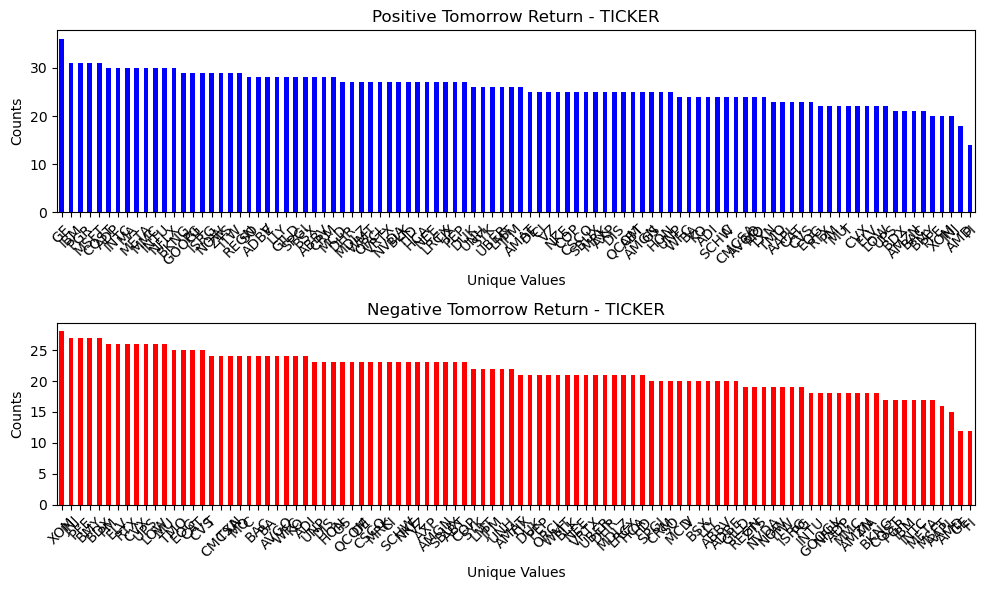

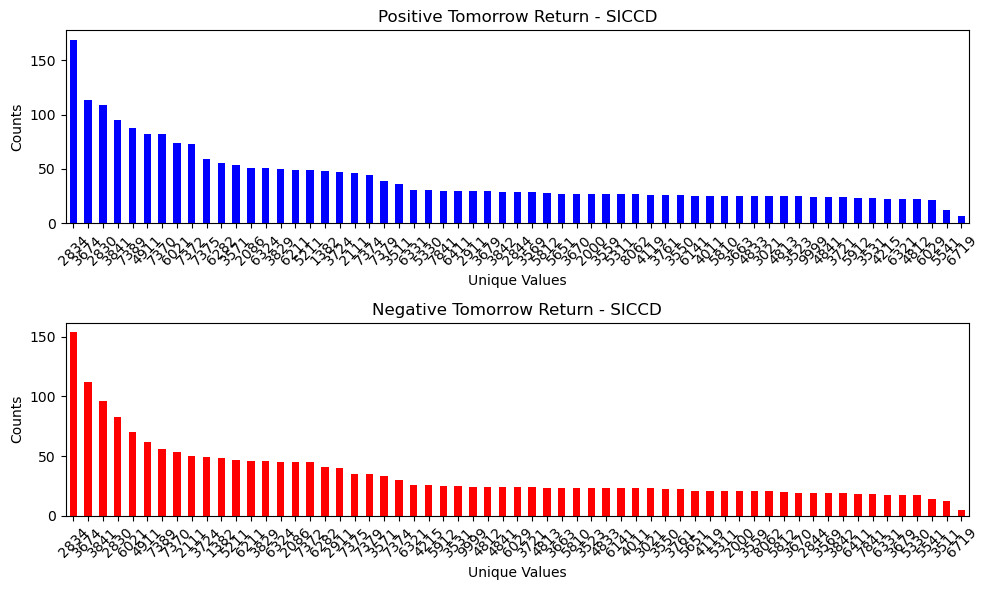

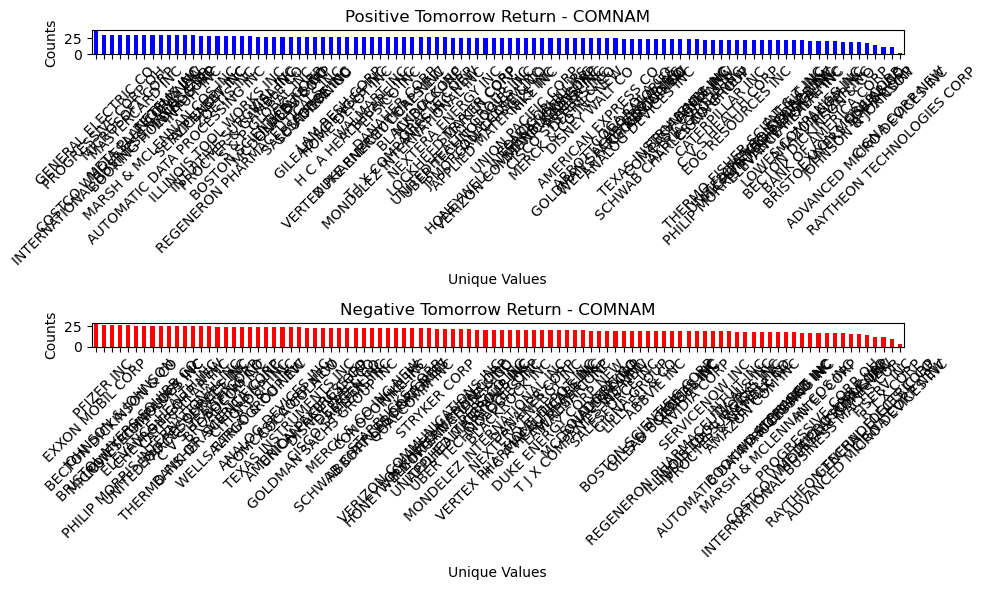

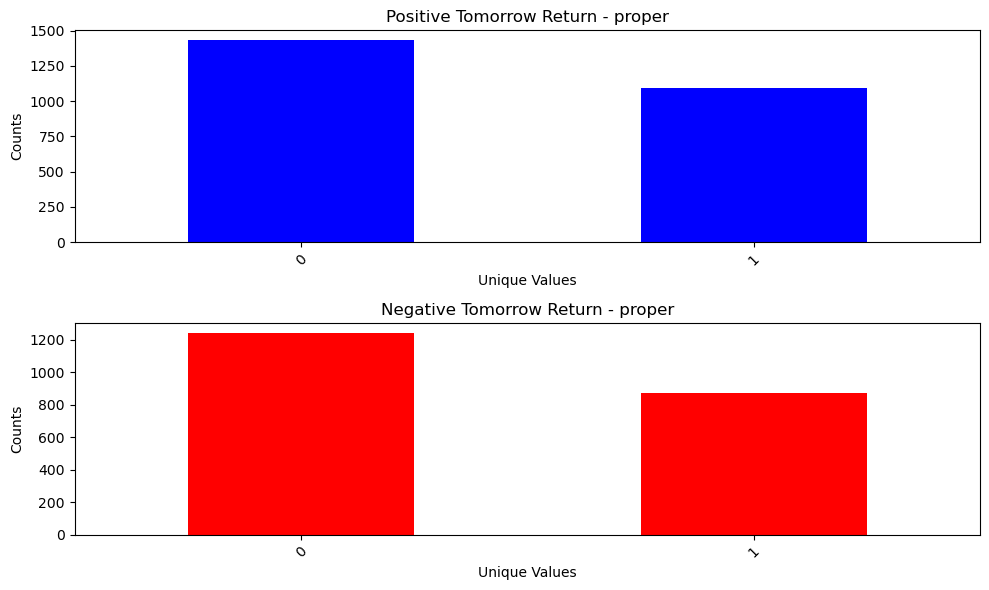

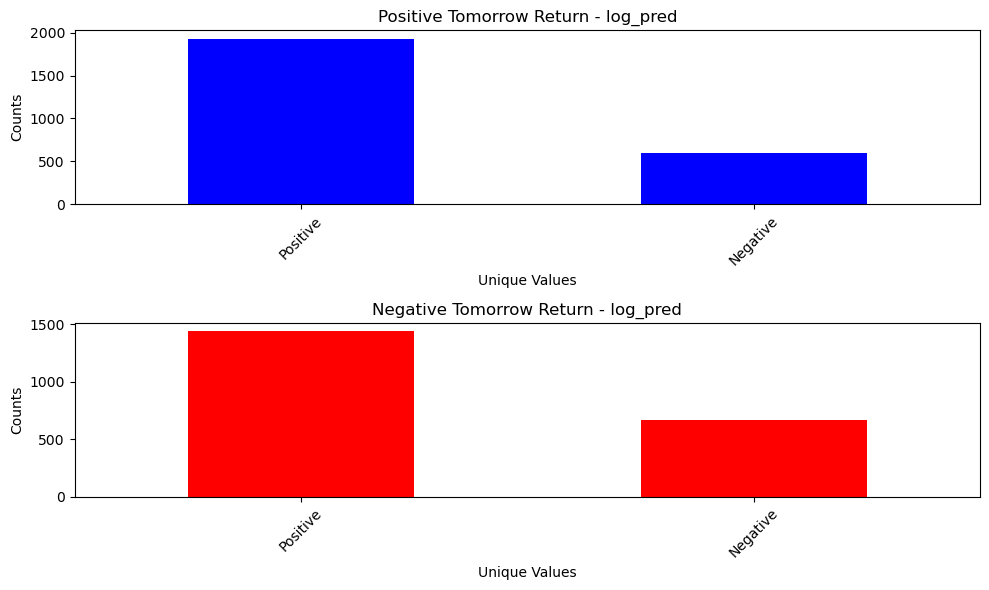

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Drop rows with NaN values in 'next_week_return' column
nasdaq.dropna(subset=['next_week_return'], inplace=True)

# Select only categorical columns
categorical_columns = nasdaq.select_dtypes(include=['object'])

# Create subsets
positive_return = nasdaq[nasdaq['next_week_return'] >= 0]
negative_return = nasdaq[nasdaq['next_week_return'] < 0]

# Plot bar charts for each unique value in categorical columns
for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    
    # Positive return subset
    plt.subplot(2, 1, 1)
    positive_counts = positive_return[column].value_counts()
    positive_counts.plot(kind='bar', color='blue')
    plt.title(f'Positive Tomorrow Return - {column}')
    plt.xlabel('Unique Values')
    plt.ylabel('Counts')
    plt.xticks(rotation=45)
    
    # Negative return subset
    plt.subplot(2, 1, 2)
    negative_counts = negative_return[column].value_counts()
    negative_counts.plot(kind='bar', color='red')
    plt.title(f'Negative Tomorrow Return - {column}')
    plt.xlabel('Unique Values')
    plt.ylabel('Counts')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

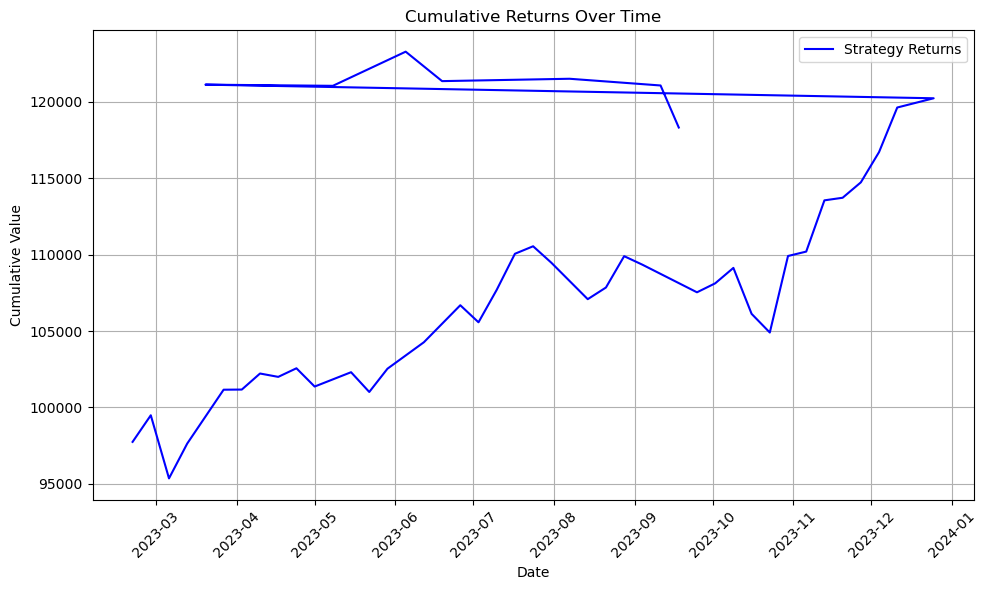

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
nasdaq_copy = nasdaq.copy()

# Convert 'date' column to datetime format
nasdaq_copy['date'] = pd.to_datetime(nasdaq_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
nasdaq_copy = nasdaq_copy[nasdaq_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
nasdaq_copy.loc[(nasdaq_copy['dummy_total'] == 1), 'position'] = 1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate weekly mode of 'sprtrn' for S&P 500
weekly_mode_sprtrn = nasdaq_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = nasdaq_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = nasdaq_copy[nasdaq_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = weekly_mode_sprtrn[weekly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_week_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


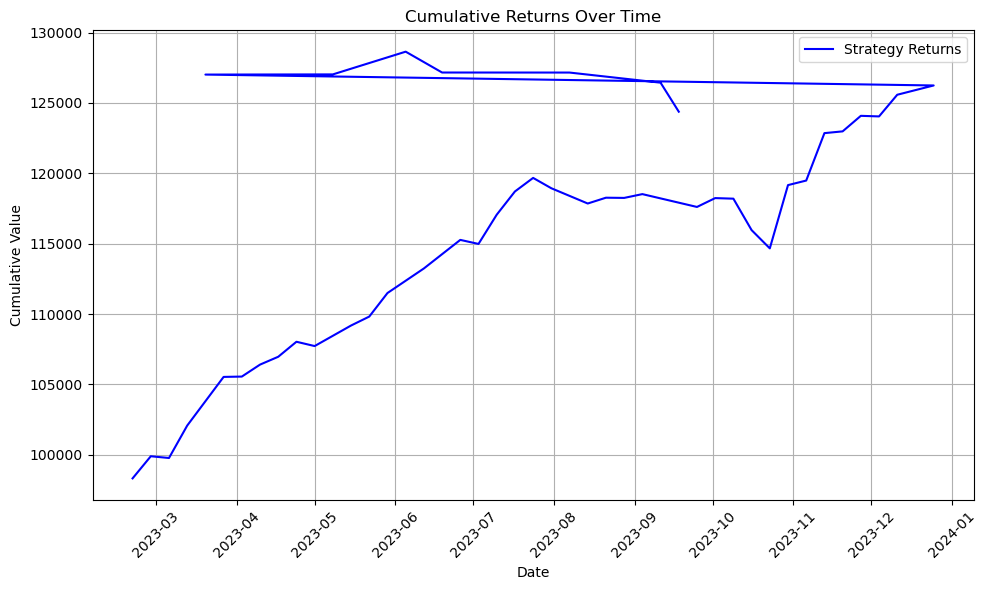

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
nasdaq_copy = nasdaq.copy()

# Convert 'date' column to datetime format
nasdaq_copy['date'] = pd.to_datetime(nasdaq_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
nasdaq_copy = nasdaq_copy[nasdaq_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
nasdaq_copy['position'] = 0
nasdaq_copy.loc[(nasdaq_copy['lasso_pred'] > 0), 'position'] = 1
nasdaq_copy.loc[(nasdaq_copy['lasso_pred'] < 0), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate weekly mode of 'sprtrn' for S&P 500
weekly_mode_sprtrn = nasdaq_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = nasdaq_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = nasdaq_copy[nasdaq_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = weekly_mode_sprtrn[weekly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_week_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


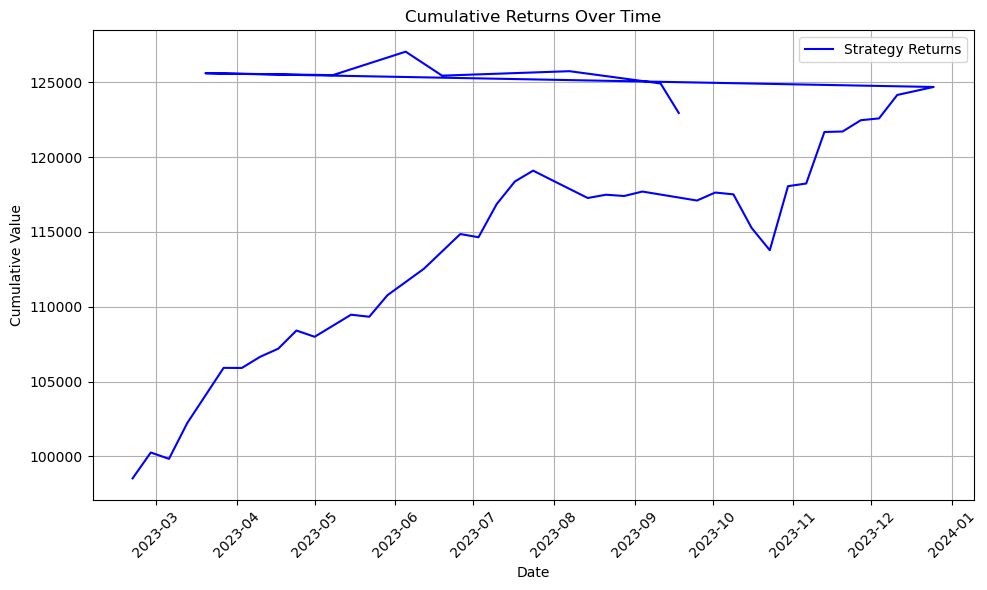

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
nasdaq_copy = nasdaq.copy()

# Convert 'date' column to datetime format
nasdaq_copy['date'] = pd.to_datetime(nasdaq_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
nasdaq_copy = nasdaq_copy[nasdaq_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
nasdaq_copy['position'] = 0
nasdaq_copy.loc[(nasdaq_copy['lasso_pred'] > 0) & (nasdaq_copy['dummy_total'] == 1), 'position'] = 1
nasdaq_copy.loc[(nasdaq_copy['lasso_pred'] < 0) & (nasdaq_copy['dummy_total'] == 1), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate weekly mode of 'sprtrn' for S&P 500
weekly_mode_sprtrn = nasdaq_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = nasdaq_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = nasdaq_copy[nasdaq_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = weekly_mode_sprtrn[weekly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_week_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


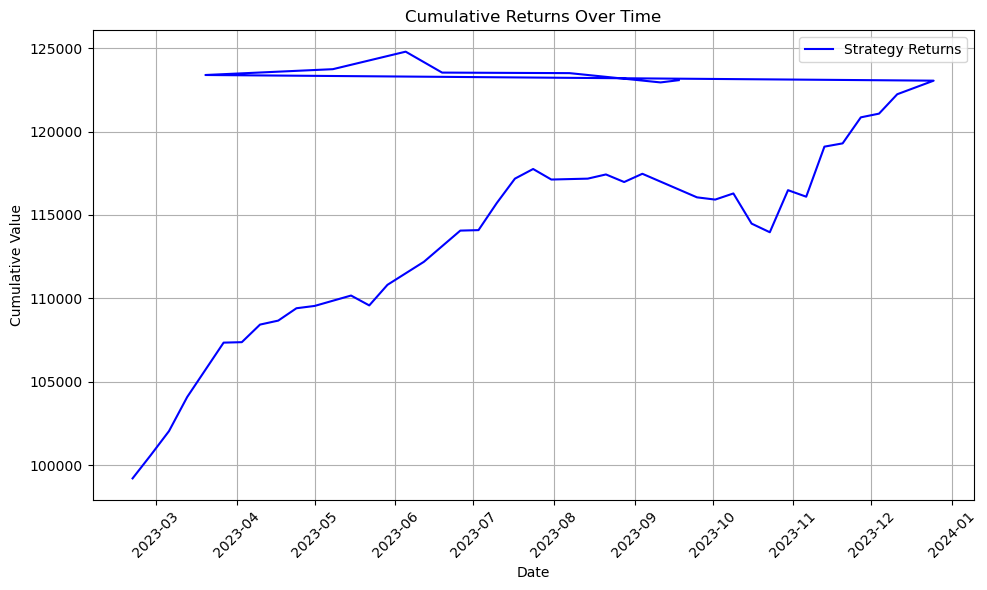

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
nasdaq_copy = nasdaq.copy()

# Convert 'date' column to datetime format
nasdaq_copy['date'] = pd.to_datetime(nasdaq_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
nasdaq_copy = nasdaq_copy[nasdaq_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
nasdaq_copy['position'] = 0
nasdaq_copy.loc[(nasdaq_copy['log_pred'] == 'Positive'), 'position'] = 1
nasdaq_copy.loc[(nasdaq_copy['log_pred'] == 'Negative'), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate weekly mode of 'sprtrn' for S&P 500
weekly_mode_sprtrn = nasdaq_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = nasdaq_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = nasdaq_copy[nasdaq_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = weekly_mode_sprtrn[weekly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_week_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


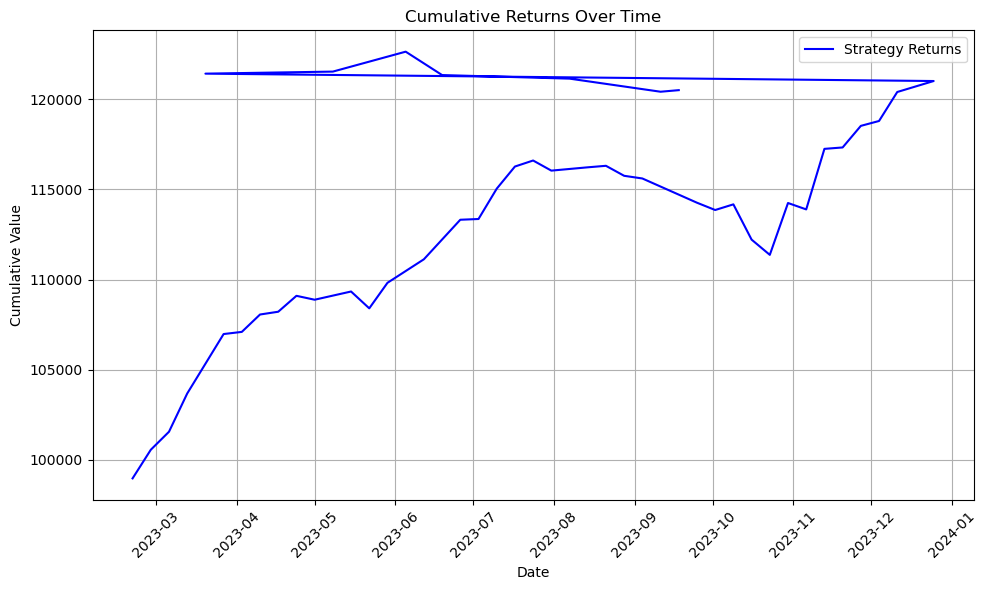

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
nasdaq_copy = nasdaq.copy()

# Convert 'date' column to datetime format
nasdaq_copy['date'] = pd.to_datetime(nasdaq_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
nasdaq_copy = nasdaq_copy[nasdaq_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
nasdaq_copy['position'] = 0
nasdaq_copy.loc[(nasdaq_copy['log_pred'] == 'Positive') & (nasdaq_copy['dummy_total'] == 1), 'position'] = 1
nasdaq_copy.loc[(nasdaq_copy['log_pred'] == 'Negative') & (nasdaq_copy['dummy_total'] == 1), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate weekly mode of 'sprtrn' for S&P 500
weekly_mode_sprtrn = nasdaq_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = nasdaq_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = nasdaq_copy[nasdaq_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = weekly_mode_sprtrn[weekly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_week_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


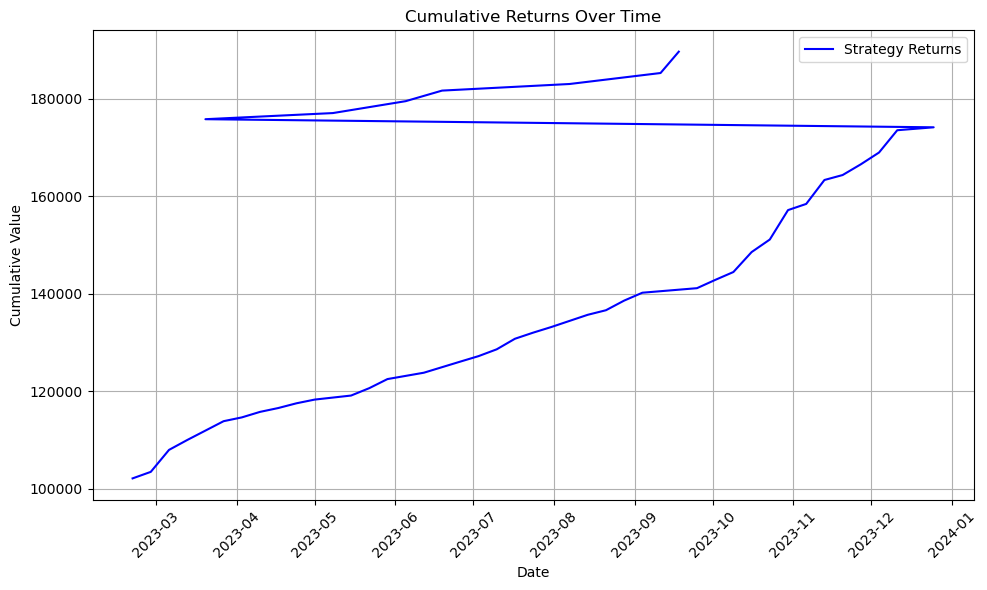

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
nasdaq_copy = nasdaq.copy()

# Convert 'date' column to datetime format
nasdaq_copy['date'] = pd.to_datetime(nasdaq_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
nasdaq_copy = nasdaq_copy[nasdaq_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
nasdaq_copy['position'] = 0
nasdaq_copy.loc[(nasdaq_copy['pred_forest'] > 0), 'position'] = 1
nasdaq_copy.loc[(nasdaq_copy['pred_forest'] < 0), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate weekly mode of 'sprtrn' for S&P 500
weekly_mode_sprtrn = nasdaq_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = nasdaq_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = nasdaq_copy[nasdaq_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = weekly_mode_sprtrn[weekly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_week_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


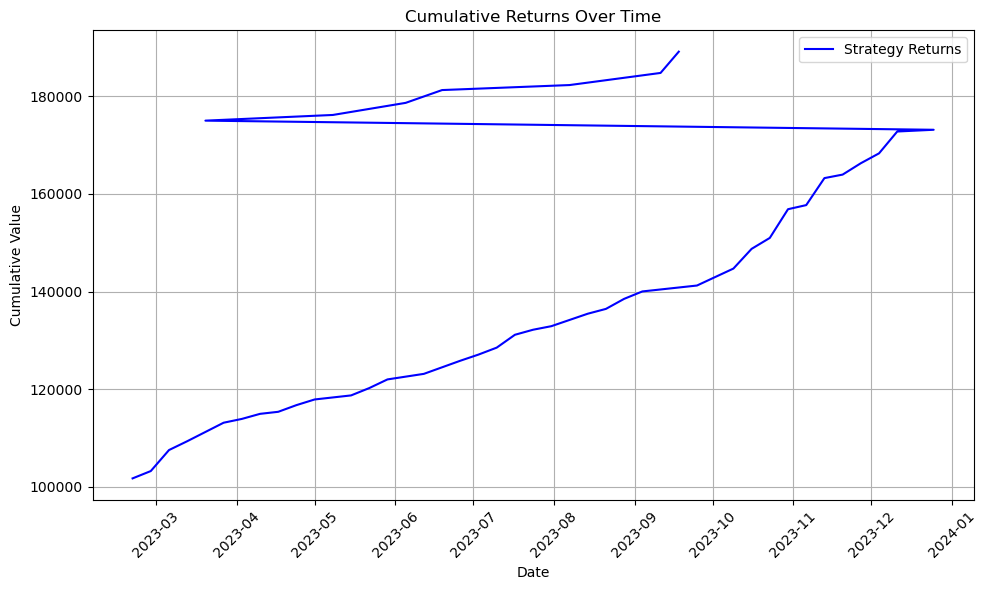

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
nasdaq_copy = nasdaq.copy()

# Convert 'date' column to datetime format
nasdaq_copy['date'] = pd.to_datetime(nasdaq_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
nasdaq_copy = nasdaq_copy[nasdaq_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
nasdaq_copy['position'] = 0
nasdaq_copy.loc[(nasdaq_copy['pred_forest'] > 0) & (nasdaq_copy['dummy_total'] == 1), 'position'] = 1
nasdaq_copy.loc[(nasdaq_copy['pred_forest'] < 0) & (nasdaq_copy['dummy_total'] == 1), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate weekly mode of 'sprtrn' for S&P 500
weekly_mode_sprtrn = nasdaq_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = nasdaq_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = nasdaq_copy[nasdaq_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = weekly_mode_sprtrn[weekly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_week_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


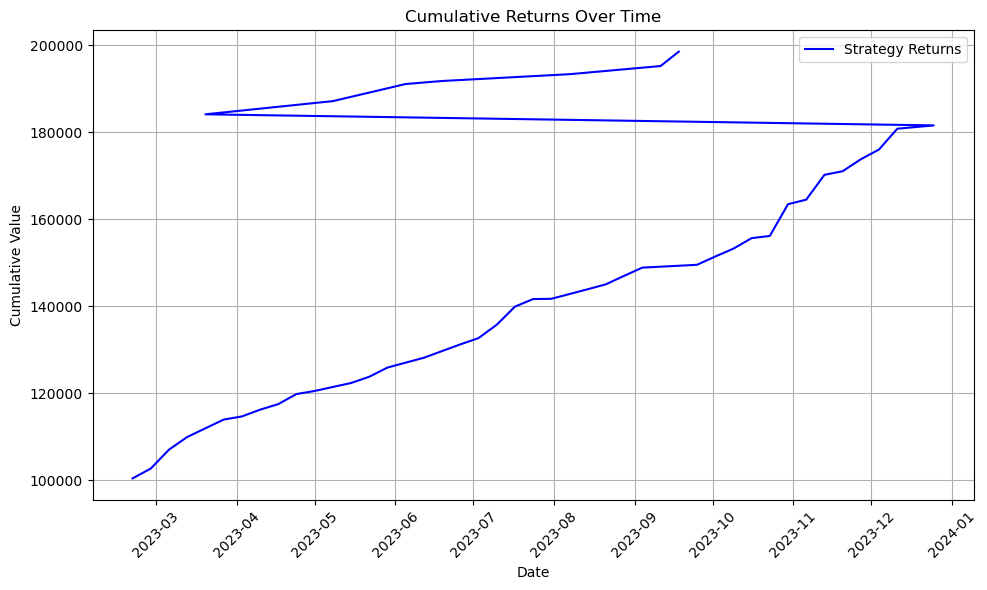

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
nasdaq_copy = nasdaq.copy()

# Convert 'date' column to datetime format
nasdaq_copy['date'] = pd.to_datetime(nasdaq_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
nasdaq_copy = nasdaq_copy[nasdaq_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
nasdaq_copy['position'] = 0
nasdaq_copy.loc[(nasdaq_copy['pred_forest'] > 0) & (nasdaq_copy['lasso_pred'] > 0) & (nasdaq_copy['dummy_total'] == 1), 'position'] = 1
nasdaq_copy.loc[(nasdaq_copy['pred_forest'] < 0) & (nasdaq_copy['lasso_pred'] < 0) & (nasdaq_copy['dummy_total'] == 1), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate weekly mode of 'sprtrn' for S&P 500
weekly_mode_sprtrn = nasdaq_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = nasdaq_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = nasdaq_copy[nasdaq_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = weekly_mode_sprtrn[weekly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_week_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


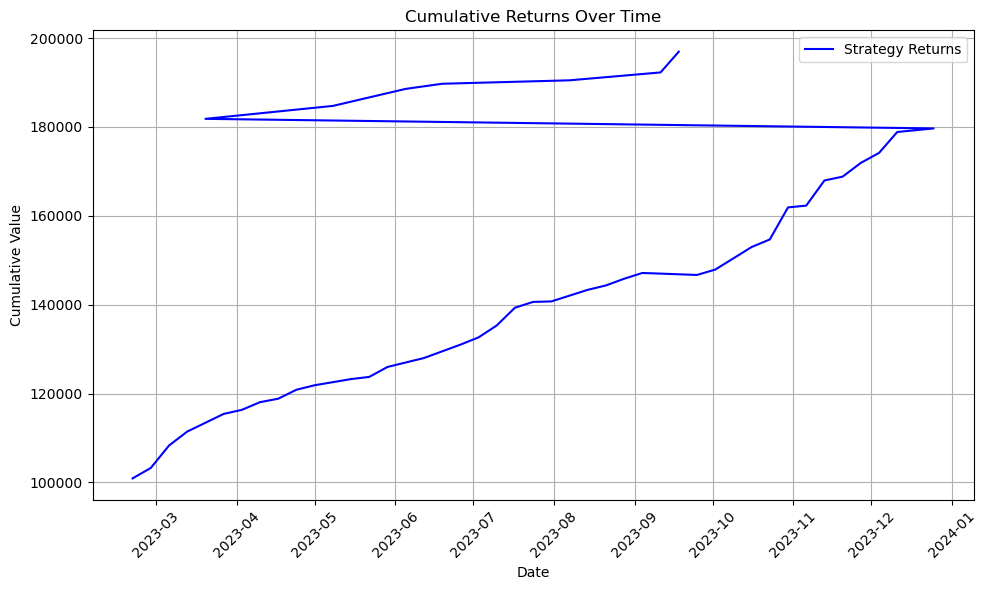

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
nasdaq_copy = nasdaq.copy()

# Convert 'date' column to datetime format
nasdaq_copy['date'] = pd.to_datetime(nasdaq_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
nasdaq_copy = nasdaq_copy[nasdaq_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
nasdaq_copy['position'] = 0
nasdaq_copy.loc[(nasdaq_copy['pred_forest'] > 0) & (nasdaq_copy['log_pred'] == 'Positive') & (nasdaq_copy['dummy_total'] == 1), 'position'] = 1
nasdaq_copy.loc[(nasdaq_copy['pred_forest'] < 0) & (nasdaq_copy['log_pred'] == 'Negative') & (nasdaq_copy['dummy_total'] == 1), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate weekly mode of 'sprtrn' for S&P 500
weekly_mode_sprtrn = nasdaq_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = nasdaq_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = nasdaq_copy[nasdaq_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = weekly_mode_sprtrn[weekly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_week_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


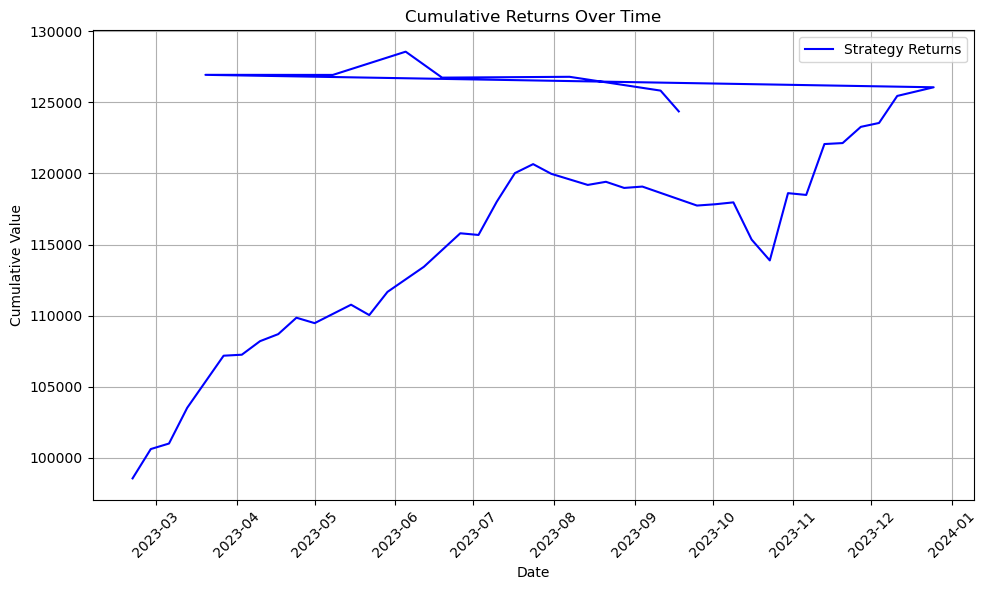

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
nasdaq_copy = nasdaq.copy()

# Convert 'date' column to datetime format
nasdaq_copy['date'] = pd.to_datetime(nasdaq_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
nasdaq_copy = nasdaq_copy[nasdaq_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
nasdaq_copy['position'] = 0
nasdaq_copy.loc[(nasdaq_copy['log_pred'] == 'Positive') & (nasdaq_copy['lasso_pred'] > 0) & (nasdaq_copy['dummy_total'] == 1), 'position'] = 1
nasdaq_copy.loc[(nasdaq_copy['log_pred'] == 'Negative') & (nasdaq_copy['lasso_pred'] < 0) & (nasdaq_copy['dummy_total'] == 1), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate weekly mode of 'sprtrn' for S&P 500
weekly_mode_sprtrn = nasdaq_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = nasdaq_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = nasdaq_copy[nasdaq_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = weekly_mode_sprtrn[weekly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_week_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


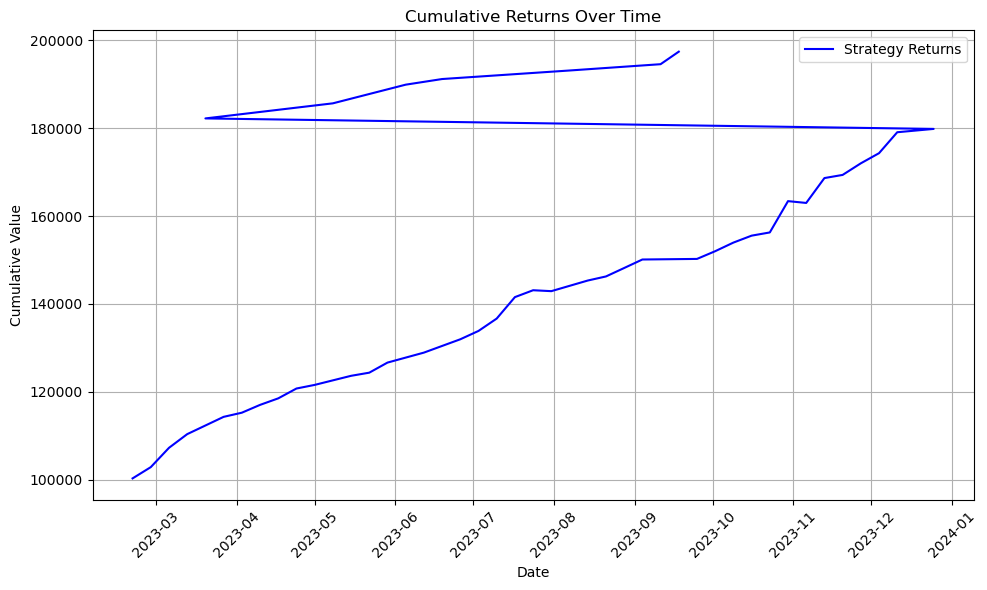

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
nasdaq_copy = nasdaq.copy()

# Convert 'date' column to datetime format
nasdaq_copy['date'] = pd.to_datetime(nasdaq_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
nasdaq_copy = nasdaq_copy[nasdaq_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
nasdaq_copy['position'] = 0
nasdaq_copy.loc[(nasdaq_copy['pred_forest'] > 0) & (nasdaq_copy['lasso_pred'] > 0) & (nasdaq_copy['dummy_total'] == 1) & (nasdaq_copy['log_pred'] == 'Positive'), 'position'] = 1
nasdaq_copy.loc[(nasdaq_copy['pred_forest'] < 0) & (nasdaq_copy['lasso_pred'] < 0) & (nasdaq_copy['dummy_total'] == 1) & (nasdaq_copy['log_pred'] == 'Negative'), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate weekly mode of 'sprtrn' for S&P 500
weekly_mode_sprtrn = nasdaq_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = nasdaq_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = nasdaq_copy[nasdaq_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = weekly_mode_sprtrn[weekly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_week_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
